In this notebook, we will study how homeostasis (cooperation) may be an essential ingredient to this algorithm working on a winner-take-all basis (competition). This extension has been published as Perrinet, Neural Computation (2010) (see  https://laurentperrinet.github.io/publication/perrinet-10-shl ). Compared to other posts, such as this [previous post](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps-fastpcum.html), we improve the code to not depend on any parameter (namely the ``C``parameter of the rescaling function). For that, we will use a non-parametric approach based on the use of cumulative histograms.


This is joint work with [Victor Boutin](https://laurentperrinet.github.io/authors/victor-boutin) and [Angelo Francisioni](https://laurentperrinet.github.io/author/angelo-franciosini/). See also the other posts on [unsupervised learning](https://laurentperrinet.github.io/sciblog/categories/learning.html).

<!-- TEASER_END -->


In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
np.set_printoptions(formatter = dict( float = lambda x: "%.3g" % x ), precision=3, suppress=True, threshold=np.inf)
from shl_scripts.shl_experiments import SHL
import time
%load_ext autoreload
%autoreload 2

In [2]:
DEBUG = True
DEBUG = False
if not DEBUG:
    tag = '2017-12-01_Testing_COMPs'
    DEBUG_DOWNSCALE = 1
else:
    tag = '2017-12-01_Testing_COMPs-DEBUG'
    DEBUG_DOWNSCALE = 10

seed = 42
nb_quant = 512
C = 0.
do_sym = False
verbose = False
i_sample = 42

from shl_scripts.shl_experiments import SHL
matname = tag + '_nohomeo'
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE,
          datapath='/tmp/database', seed=seed, 
          eta=0.05, verbose=2, record_each=50, n_iter=1000, 
          eta_homeo=0., alpha_homeo=1., 
          do_sym=do_sym, nb_quant=nb_quant)
data = shl.get_data(matname=matname)

loading the data called : data_cache/2017-12-01_Testing_COMPs_nohomeo_data


In [3]:
test_size = shl.batch_size # data.shape[0]//2
data_training = data[:test_size, :]
data_test = data[test_size:,:]   
if DEBUG:
    test_size = data.shape[0]//20
    data_training = data[:(data.shape[0]-test_size),:].copy()
    data_test = data[:test_size, :].copy()

In [4]:
dico_partial_learning = shl.learn_dico(data=data_training, matname=matname)

loading the dico called : data_cache/2017-12-01_Testing_COMPs_nohomeo_dico.pkl


We start off by using a short learning with no homeostasis such that we end up with a unbalanced dictionary:

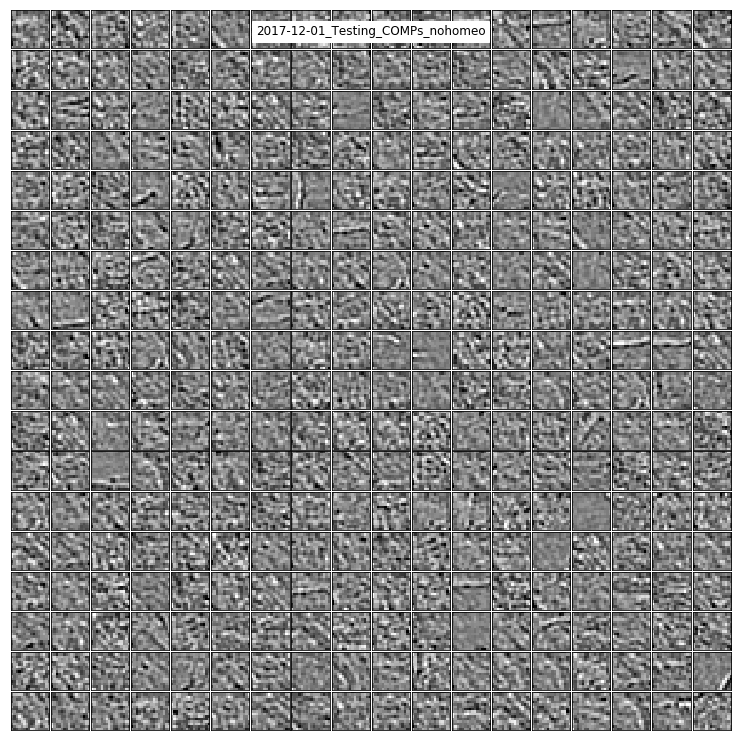

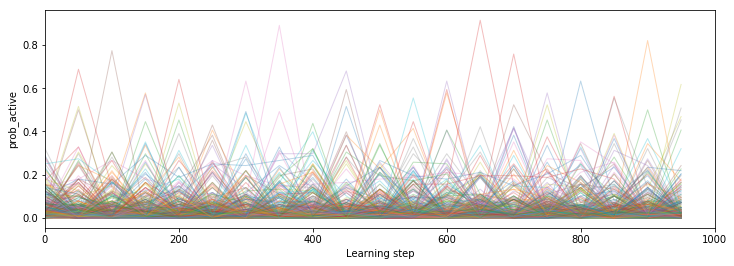

In [5]:
fig, ax = shl.show_dico(dico_partial_learning, data=data, title=matname)
fig.show()
fig, ax = shl.time_plot(dico_partial_learning, variable='prob_active');
fig.show()

## MP classique

loading the code called : data_cache/2017-12-01_Testing_COMPs_nohomeo_coding.npy


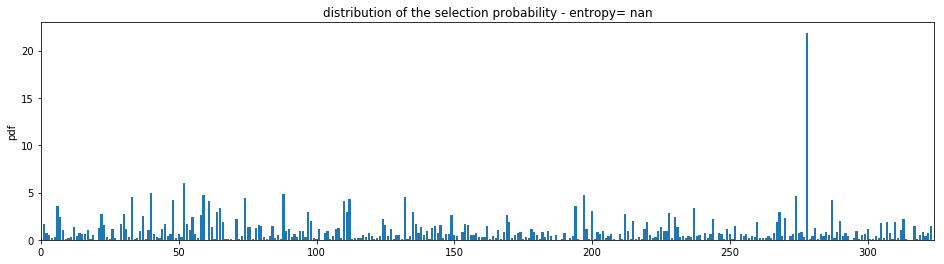

In [6]:
n_samples, n_pixels = data_test.shape
n_dictionary, n_pixels = dico_partial_learning.dictionary.shape
norm_each_filter = np.sqrt(np.sum(dico_partial_learning.dictionary**2, axis=1))
dico_partial_learning.dictionary /= norm_each_filter[:,np.newaxis]

sparse_code_mp = shl.code(data_test, dico_partial_learning, matname=matname)

from shl_scripts.shl_tools import plot_proba_histogram
fig, ax = plot_proba_histogram(sparse_code_mp)

## COMP : learning rescaling on sparse coefficients - basic principle

In [7]:
n_samples, n_dictionary = sparse_code_mp.shape
N = n_samples * n_dictionary
q = np.zeros_like(sparse_code_mp)
for i in range(i_sample, i_sample+1): #range(n_samples):
    for k in range(n_dictionary):
        if sparse_code_mp[i, k] > 0:
            q[i, k] = np.sum(sparse_code_mp[i, k]>sparse_code_mp.ravel())/N
            if q[i, k]==0:
                print(k, i, sparse_code_mp[i, k])
            if i < 22 and k < 20:
                print(i, k, 'Raw value=', sparse_code_mp[i, k], 
                  ' is transformed into=', q[i, k]) 

In [8]:
def rescaling(code, do_sym=do_sym):
    if do_sym:
        code = np.abs(code)
    else:
        code *= code>0
    n_samples, n_dictionary = code.shape
    N = n_samples * n_dictionary
    q = np.zeros_like(code)
    for i in range(n_samples):
        for k in range(n_dictionary):
            if code[i, k] > 0:
                q[i, k] = np.sum(code[i, k]>code.ravel())/N
    return q

Testing on one sample:

In [9]:
%%time
sparse_code_mp_ = rescaling(sparse_code_mp[i_sample:(i_sample+1), :], do_sym=do_sym)

CPU times: user 275 µs, sys: 10 µs, total: 285 µs
Wall time: 281 µs


In [10]:
def rescaling(code, do_sym=do_sym):
    if do_sym: code = np.abs(code)
    n_samples, n_dictionary = code.shape
    N = n_samples * n_dictionary
    q = np.sum(code[:, :, np.newaxis] > code.ravel()[np.newaxis, np.newaxis, :], axis=-1)
    return q

In [11]:
%%time
sparse_code_mp_ = rescaling(sparse_code_mp[i_sample:(i_sample+1), :], do_sym=do_sym)

CPU times: user 590 µs, sys: 545 µs, total: 1.13 ms
Wall time: 748 µs


In [12]:
def get_P_cum(code, nb_quant=512, do_rescale=True, do_sym=do_sym):
    if do_rescale:
        p_c = rescaling(code, do_sym=do_sym)

    n_samples, nb_filter = code.shape
    code_bins = np.linspace(0., 1, nb_quant, endpoint=True)
    P_cum = np.zeros((nb_filter, nb_quant))
    for i in range(nb_filter):
        p, bins = np.histogram(p_c[:, i], bins=code_bins, density=True)
        p /= p.sum()
        P_cum[i, :] = np.hstack((0, np.cumsum(p)))
    return P_cum

In [13]:
%%time
P_cum = get_P_cum(sparse_code_mp[i_sample:(i_sample+1), :], nb_quant=nb_quant, do_sym=do_sym)

CPU times: user 65.6 ms, sys: 2.27 ms, total: 67.9 ms
Wall time: 68.1 ms


## COMP : learning modulations on linear coefficients using ranks

Sparse coefficients are distributed according to:

Min= 0.0 Max= 36.576175154 Shape= (81792, 324)


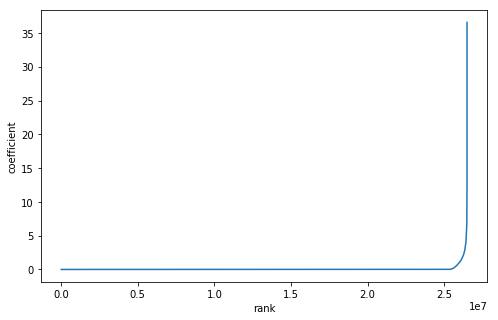

In [14]:
print('Min=', np.min(sparse_code_mp), 'Max=', np.max(sparse_code_mp), 'Shape=', sparse_code_mp.shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(np.sort(sparse_code_mp.ravel()))
ax.set_xlabel('rank'); ax.set_ylabel('coefficient');

and linear (rectified) coefficients to:

Min= -0.0 Max= 36.576175154 Shape= (81792, 324)


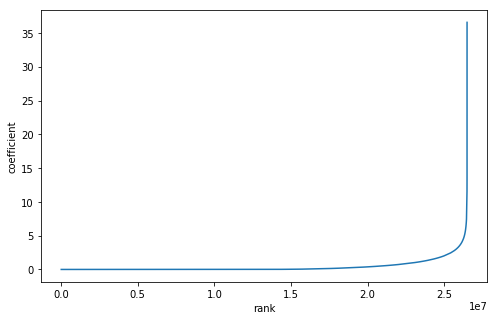

In [15]:
corr = (data_test @ dico_partial_learning.dictionary.T)
corr *= corr>0

print('Min=', np.min(corr), 'Max=', np.max(corr), 'Shape=', corr.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(np.sort(corr.ravel()))
ax.set_xlabel('rank'); ax.set_ylabel('coefficient');

The rescaling functions aims at achieving a better numerical stability, such that the quantification won't affect the learning. But it fundamentally does not change the learning algorithm. The later choice (linear rectified coefficients) seems to be a more robust choice and is similar to the prior choice of an exponential function in a past implementation.

In [16]:
def get_rescaling(code, nb_quant=nb_quant, do_sym=do_sym, verbose=False):
#     if do_sym:
#         code = np.abs(code)
#     else:
#         code *= code>0
    sorted_coeffs = np.sort(code.ravel())
    indices = [int(q*(sorted_coeffs.size-1) ) for q in np.linspace(0, 1, nb_quant, endpoint=True)]
    C = sorted_coeffs[indices]
    if verbose:
        print ('At indices (ranks) ', indices)
        print ('the coefficients are ', C )
    return C

C = get_rescaling(corr, nb_quant=nb_quant, do_sym=do_sym, verbose=True)

At indices (ranks)  [0, 51860, 103720, 155580, 207441, 259301, 311161, 363022, 414882, 466742, 518602, 570463, 622323, 674183, 726044, 777904, 829764, 881624, 933485, 985345, 1037205, 1089066, 1140926, 1192786, 1244646, 1296507, 1348367, 1400227, 1452088, 1503948, 1555808, 1607668, 1659529, 1711389, 1763249, 1815110, 1866970, 1918830, 1970690, 2022551, 2074411, 2126271, 2178132, 2229992, 2281852, 2333712, 2385573, 2437433, 2489293, 2541154, 2593014, 2644874, 2696734, 2748595, 2800455, 2852315, 2904176, 2956036, 3007896, 3059756, 3111617, 3163477, 3215337, 3267198, 3319058, 3370918, 3422778, 3474639, 3526499, 3578359, 3630220, 3682080, 3733940, 3785801, 3837661, 3889521, 3941381, 3993242, 4045102, 4096962, 4148823, 4200683, 4252543, 4304403, 4356264, 4408124, 4459984, 4511845, 4563705, 4615565, 4667425, 4719286, 4771146, 4823006, 4874867, 4926727, 4978587, 5030447, 5082308, 5134168, 5186028, 5237889, 5289749, 5341609, 5393469, 5445330, 5497190, 5549050, 5600911, 5652771, 5704631, 575649

In [17]:
def rescaling(code, C, do_sym=do_sym):
#     if do_sym:
#         code = np.abs(code)
#     else:
#         code *= code>0
    n_samples, n_dictionary = code.shape
    N = n_samples * n_dictionary
    q = np.zeros_like(code)
    code_bins = np.linspace(0., 1, C.size, endpoint=True)

    for i in range(n_samples):
        for k in range(n_dictionary):
            if code[i, k] > 0:
                q[i, k] = np.interp(code[i, k], C, code_bins)
    return q

rescaled_code_ = rescaling(corr[i_sample:(i_sample+1), :], C=C, do_sym=do_sym)

In [18]:
%%time
rescaled_code_ = rescaling(corr[i_sample:(i_sample+1), :], C=C, do_sym=do_sym)

CPU times: user 1.89 ms, sys: 1.36 ms, total: 3.25 ms
Wall time: 1.98 ms


This can be vectorized:

In [19]:
def rescaling(code, C, do_sym=do_sym):
#     if do_sym:
#         code = np.abs(code)
#     else:
#         code *= code>0
    code_bins = np.linspace(0., 1, C.size, endpoint=True)
    return np.interp(code, C, code_bins) * (code > 0.)

print('on ', corr.shape[0], ' samples')
rescaled_code_ = rescaling(corr, C=C, do_sym=do_sym)

on  81792  samples


In [20]:
%%time
sparse_code_mp_ = rescaling(sparse_code_mp, C=C, do_sym=do_sym)

CPU times: user 444 ms, sys: 117 ms, total: 561 ms
Wall time: 635 ms


We notice also that we use half of the vector for negative coefficients. This could be improved as:

In [21]:
def rescaling(code, C, do_sym=do_sym):
#     if do_sym:
#         code = np.abs(code)
#     else:
#         code *= code>0
    p_c = np.zeros_like(code)
    ind_nz = code>0.
    code_bins = np.linspace(0., 1, C.size, endpoint=True)
    p_c[ind_nz] = np.interp(code[ind_nz], C, code_bins)
    return p_c # * (code > 0.)

rescaled_code__ = rescaling(corr, C=C, do_sym=do_sym)
assert(np.array_equal(rescaled_code_, rescaled_code__))

In [22]:
%%time
sparse_code_mp_ = rescaling(sparse_code_mp, C=C, do_sym=do_sym)

CPU times: user 246 ms, sys: 131 ms, total: 377 ms
Wall time: 492 ms


Finally, one can get the ``P_cum`` look-up-tables:

In [23]:
def get_P_cum(code, nb_quant, C=C, do_sym=do_sym):
    p_c = rescaling(code, C=C, do_sym=do_sym)

    n_samples, nb_filter = code.shape
    code_bins = np.linspace(0., 1, nb_quant, endpoint=True)
    P_cum = np.zeros((nb_filter, nb_quant))
    for i in range(nb_filter):
        p, bins = np.histogram(p_c[:, i], bins=code_bins, density=True)
        p /= p.sum()
        P_cum[i, :] = np.hstack((0., np.cumsum(p)))
    return P_cum

computing histograms is rather fast:

In [24]:
%%time
P_cum = get_P_cum(sparse_code_mp, nb_quant=nb_quant, C=C)

CPU times: user 1.23 s, sys: 126 ms, total: 1.36 s
Wall time: 1.44 s


At indices (ranks)  [0, 51860, 103720, 155580, 207441, 259301, 311161, 363022, 414882, 466742, 518602, 570463, 622323, 674183, 726044, 777904, 829764, 881624, 933485, 985345, 1037205, 1089066, 1140926, 1192786, 1244646, 1296507, 1348367, 1400227, 1452088, 1503948, 1555808, 1607668, 1659529, 1711389, 1763249, 1815110, 1866970, 1918830, 1970690, 2022551, 2074411, 2126271, 2178132, 2229992, 2281852, 2333712, 2385573, 2437433, 2489293, 2541154, 2593014, 2644874, 2696734, 2748595, 2800455, 2852315, 2904176, 2956036, 3007896, 3059756, 3111617, 3163477, 3215337, 3267198, 3319058, 3370918, 3422778, 3474639, 3526499, 3578359, 3630220, 3682080, 3733940, 3785801, 3837661, 3889521, 3941381, 3993242, 4045102, 4096962, 4148823, 4200683, 4252543, 4304403, 4356264, 4408124, 4459984, 4511845, 4563705, 4615565, 4667425, 4719286, 4771146, 4823006, 4874867, 4926727, 4978587, 5030447, 5082308, 5134168, 5186028, 5237889, 5289749, 5341609, 5393469, 5445330, 5497190, 5549050, 5600911, 5652771, 5704631, 575649

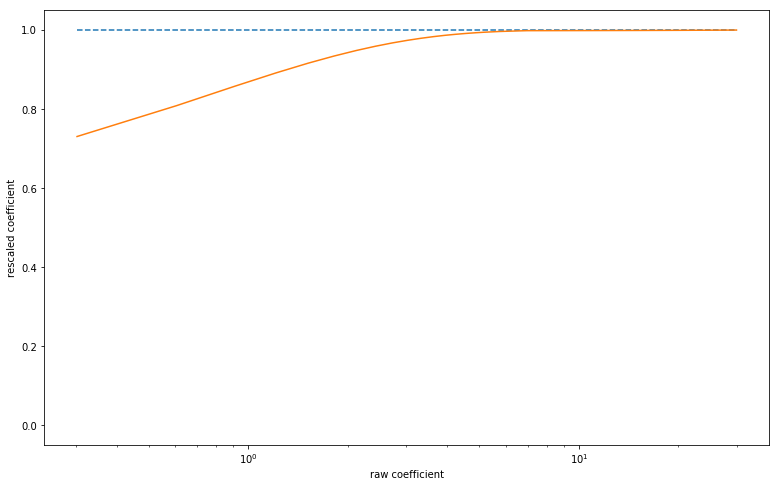

In [25]:
C = get_rescaling(corr, nb_quant=nb_quant, do_sym=do_sym, verbose=True)
C_vec_init = C.copy()
fig=plt.figure(figsize=(13, 8))
ax = plt.subplot(111)
x = np.linspace(0, 30, 100)
ax.plot(x, np.ones_like(x), '--')
ax.plot(x, rescaling(x, C=C, do_sym=do_sym))
ax.set_xlabel('raw coefficient')
ax.set_ylabel('rescaled coefficient')
ax.set_xscale('log');

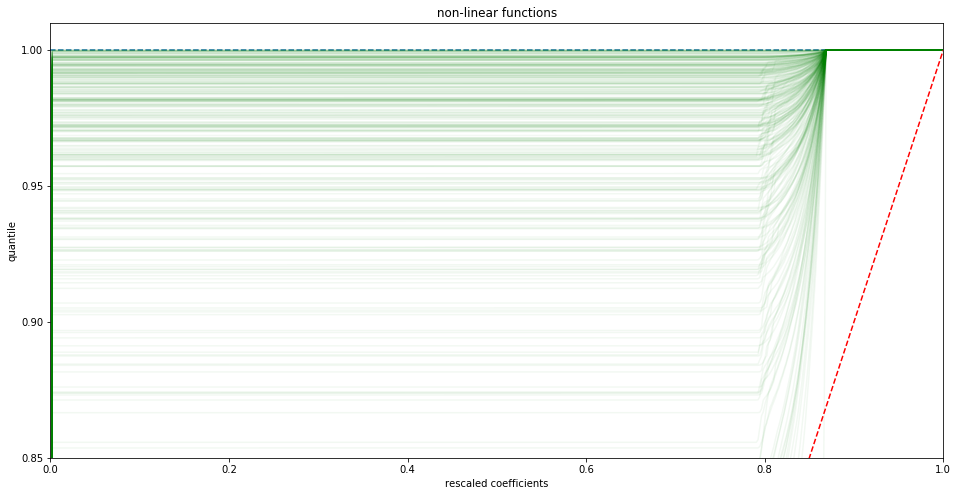

In [26]:
P_cum = get_P_cum(rescaling(sparse_code_mp, C=C, do_sym=do_sym), nb_quant=nb_quant, C=C, do_sym=do_sym)
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum, verbose=False, alpha=.05)
ax.plot([0, 1], [0, 1], 'r--');
ax.set_ylim(0.85, 1.01);ax.set_xlim(0., 1.);

 Finally, we notice that the ``C`` vector is of the same length as each ``P_cum`` vector and we will integrate it to this array to ease message passing.

## COMP : optimizing the quantile function

These ``quantile`` and ``rescaling`` functions are implanted in the ``shl_scripts``:

In [27]:
from shl_scripts.shl_encode import quantile, rescaling

corr = (data_test @ dico_partial_learning.dictionary.T)
#corr *= corr>0
print('correlation=', corr[i_sample, :])
print('transformed correlation=', rescaling(corr, C=C, do_sym=do_sym)[i_sample, :])

correlation= [-0.606 0.428 -0.566 -0.457 0.304 0.687 0.55 -1.84 0.43 0.755 -0.286 0.173
 0.365 -0.185 0.615 0.263 0.614 0.819 -1.68 1.78 0.0753 -0.536 0.404 -1.77
 1.14 0.117 0.625 -0.296 -0.0527 0.591 0.175 -0.639 0.812 0.0353 0.825 1.07
 1.97 -0.282 0.187 -0.305 -1.18 0.818 -0.2 1.31 -0.218 -1.13 0.809 0.509
 0.069 -0.673 -0.131 -0.165 -0.0833 -1.9 -0.244 -0.414 -0.0485 0.718 -0.154
 0.374 0.0455 1.17 -0.048 1.44 0.602 0.00801 -1.67 1.16 0.307 -0.152 1.36
 -0.173 0.444 -0.175 0.561 1.35 -0.738 1.36 2.26 0.855 0.666 0.527 -0.456
 1.3 0.556 -0.217 -0.28 1.52 0.744 -0.307 -1.02 0.891 6.32e-05 1.09 -1.94
 0.568 -0.473 1.05 0.245 0.163 1.13 -0.0183 0.686 0.543 0.379 0.6 1.38
 0.456 2.21 -1.09 0.411 -0.872 2.18 -0.301 0.681 1.35 0.568 -0.337 1.66
 -1.09 -0.486 -0.598 -0.241 1.52 -0.126 0.42 -0.0964 -1.19 1.09 0.0617
 0.542 -0.0428 -1.21 0.549 -0.385 0.2 0.0937 -0.74 -0.845 -0.783 0.0349
 0.973 1.13 -0.306 -1.02 0.0624 0.0613 -0.278 0.967 -0.658 0.579 -0.0586
 -0.463 -0.726 0.412 -0.0301 0.

At indices (ranks)  [0, 51860, 103720, 155580, 207441, 259301, 311161, 363022, 414882, 466742, 518602, 570463, 622323, 674183, 726044, 777904, 829764, 881624, 933485, 985345, 1037205, 1089066, 1140926, 1192786, 1244646, 1296507, 1348367, 1400227, 1452088, 1503948, 1555808, 1607668, 1659529, 1711389, 1763249, 1815110, 1866970, 1918830, 1970690, 2022551, 2074411, 2126271, 2178132, 2229992, 2281852, 2333712, 2385573, 2437433, 2489293, 2541154, 2593014, 2644874, 2696734, 2748595, 2800455, 2852315, 2904176, 2956036, 3007896, 3059756, 3111617, 3163477, 3215337, 3267198, 3319058, 3370918, 3422778, 3474639, 3526499, 3578359, 3630220, 3682080, 3733940, 3785801, 3837661, 3889521, 3941381, 3993242, 4045102, 4096962, 4148823, 4200683, 4252543, 4304403, 4356264, 4408124, 4459984, 4511845, 4563705, 4615565, 4667425, 4719286, 4771146, 4823006, 4874867, 4926727, 4978587, 5030447, 5082308, 5134168, 5186028, 5237889, 5289749, 5341609, 5393469, 5445330, 5497190, 5549050, 5600911, 5652771, 5704631, 575649

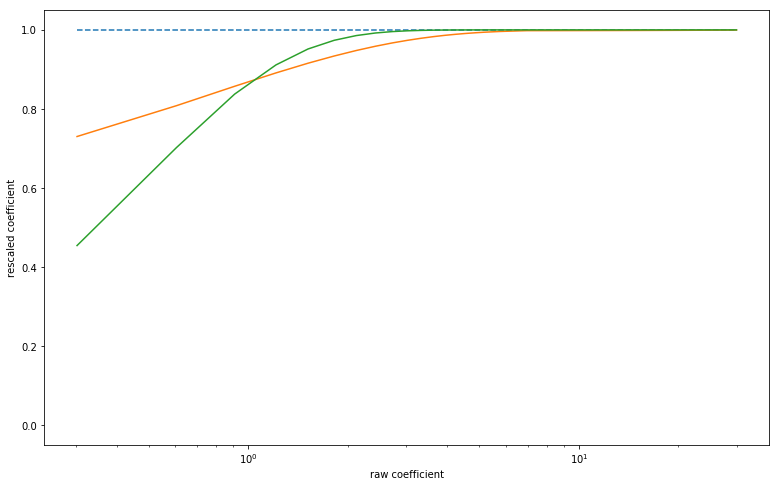

In [28]:
C = get_rescaling(corr, nb_quant=nb_quant, do_sym=do_sym, verbose=True)
fig=plt.figure(figsize=(13, 8))
ax = plt.subplot(111)
x = np.linspace(0, 30, 100)
ax.plot(x, np.ones_like(x), '--')
ax.plot(x, rescaling(x, C=C_vec_init, do_sym=do_sym))
ax.plot(x, rescaling(x, C=.5, do_sym=do_sym))
ax.set_xlabel('raw coefficient')
ax.set_ylabel('rescaled coefficient')
ax.set_xscale('log')
ax.axis('tight');

A sanity check with extremal values:

In [29]:
stick = np.arange(shl.n_dictionary)*nb_quant
print('Value for ones = ', rescaling(np.inf*np.ones(shl.n_dictionary), C=C))
print('Value for zeros = ', rescaling(np.zeros(shl.n_dictionary), C=C))

Value for ones =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Value for zeros =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

In [30]:
print('Value for ones = ', quantile(P_cum, rescaling(np.inf*np.ones(shl.n_dictionary), C=C), stick))
print('Value for zeros = ', quantile(P_cum, rescaling(np.zeros(shl.n_dictionary), C=C), stick))

Value for ones =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Value for zeros =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

a ``P_cum`` array that should not change anything to the way we chose filters:

In [31]:
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((n_dictionary, 1))

(81792, 324) (81792, 324)


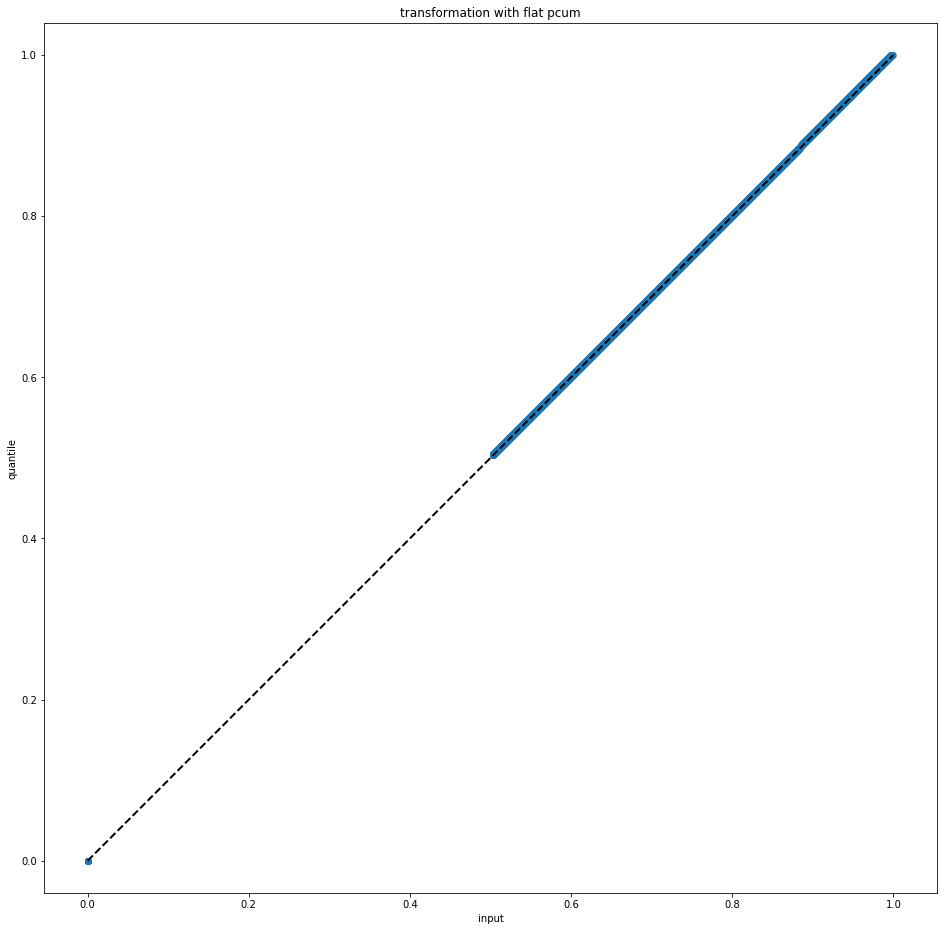

In [32]:
def plot_scatter_MpVsComp(sparse_vector, my_sparse_code, title='MP', xlabel='MP', ylabel='COMP'):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    a_min = np.min((sparse_vector.min(), my_sparse_code.min()))
    a_max = np.max((sparse_vector.max(), my_sparse_code.max()))
    ax.plot(np.array([a_min, a_max]), np.array([a_min, a_max]), 'k--', lw=2)
    print(sparse_vector.shape, my_sparse_code.shape)
    ax.scatter(sparse_vector.ravel(), my_sparse_code.ravel(), alpha=0.01)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    #ax.set_xlim(0)
    #ax.set_ylim(0)
    ax.axis('equal')
    return fig, ax

p_c = rescaling(corr, C=C, do_sym=do_sym)
fig, ax = plot_scatter_MpVsComp(p_c, quantile(P_cum_zeroeffect, p_c, stick), 
                                title='transformation with flat pcum', xlabel='input', ylabel='quantile')

The relative mean squared error is low:

In [33]:
print('Relative difference = ', np.sum( (p_c - quantile(P_cum_zeroeffect, p_c, stick))**2) / np.sum(p_c**2))

Relative difference =  3.82686497427e-06


## COMP : using modulations

let's use this new ``rescaling`` function 

In [34]:
l0_sparseness = shl.l0_sparseness
def comp(data, dico, P_cum, C=C, do_sym=do_sym, verbose=0):
    if verbose!=0: t0 = time.time()
    n_samples, n_dictionary = data.shape[0], dico.shape[0]
    sparse_code = np.zeros((n_samples, n_dictionary))
    corr = (data @ dico.T)
    Xcorr = (dico @ dico.T)
    nb_quant = P_cum.shape[1]
    stick = np.arange(n_dictionary)*nb_quant
    
    for i_sample in range(n_samples):
        c = corr[i_sample, :].copy()
        if verbose!=0: ind_list=list()
        for i_l0 in range(int(l0_sparseness)):
            if P_cum is None:
                q_i = rescaling(c, C=C, do_sym=do_sym)
            else:
                q_i = quantile(P_cum, rescaling(c, C=C, do_sym=do_sym), stick, do_fast=True)
            ind  = np.argmax(q_i)
            if verbose!=0: ind_list.append(ind)

            c_ind = c[ind] / Xcorr[ind, ind]
            sparse_code[i_sample, ind] += c_ind
            c -= c_ind * Xcorr[ind, :]

        if verbose!=0 and i_sample in range(2):
            q_i = quantile(P_cum, rescaling(c, C=C, do_sym=do_sym), stick)
            print(ind_list, [q_i[i] for i in ind_list], np.median(q_i), q_i.max(), [c[i] for i in ind_list], c.min(), c.max())
    if verbose!=0:
        duration = time.time()-t0
        print('coding duration : {0}s'.format(duration))
    return sparse_code

corr = (data_test @ dico_partial_learning.dictionary.T)
C = get_rescaling(corr, nb_quant=nb_quant, verbose=True)
sparse_code = comp(data_test, dico_partial_learning.dictionary, P_cum_zeroeffect, C=C, do_sym=do_sym, verbose=1)

At indices (ranks)  [0, 51860, 103720, 155580, 207441, 259301, 311161, 363022, 414882, 466742, 518602, 570463, 622323, 674183, 726044, 777904, 829764, 881624, 933485, 985345, 1037205, 1089066, 1140926, 1192786, 1244646, 1296507, 1348367, 1400227, 1452088, 1503948, 1555808, 1607668, 1659529, 1711389, 1763249, 1815110, 1866970, 1918830, 1970690, 2022551, 2074411, 2126271, 2178132, 2229992, 2281852, 2333712, 2385573, 2437433, 2489293, 2541154, 2593014, 2644874, 2696734, 2748595, 2800455, 2852315, 2904176, 2956036, 3007896, 3059756, 3111617, 3163477, 3215337, 3267198, 3319058, 3370918, 3422778, 3474639, 3526499, 3578359, 3630220, 3682080, 3733940, 3785801, 3837661, 3889521, 3941381, 3993242, 4045102, 4096962, 4148823, 4200683, 4252543, 4304403, 4356264, 4408124, 4459984, 4511845, 4563705, 4615565, 4667425, 4719286, 4771146, 4823006, 4874867, 4926727, 4978587, 5030447, 5082308, 5134168, 5186028, 5237889, 5289749, 5341609, 5393469, 5445330, 5497190, 5549050, 5600911, 5652771, 5704631, 575649

[112, 33, 278, 97, 101, 256, 30, 177, 36, 58, 59, 278, 88, 22, 278, 317] [0.66653387130965935, 0.65052856048959673, 0.59830775238067113, 0.62302444001996959, 0.64458959926104442, 0.64085691898403307, 0.61400716999153337, 0.57881440167231402, 0.0, 0.55064929939865515, 0.62791281020614631, 0.59830775238067113, 0.53729111115839245, 0.66534963023112492, 0.59830775238067113, 0.0] 0.0 0.726428524852 [0.14622114532348629, 0.11726767443482161, 0.04961471253073943, 0.075987077275044848, 0.10740013301351933, 0.10148169743045644, 0.065259558267194429, 0.034756512475519329, -0.026039702037990109, 0.019488148020597243, 0.082498085429622031, 0.04961471253073943, 0.013389142092147963, 0.14397244131880477, 0.04961471253073943, 0.0] -0.999707454888 0.287689288868
[200, 33, 73, 266, 6, 308, 278, 157, 137, 162, 194, 30, 290, 274, 212, 278] [0.52657777111988913, 0.0, 0.52231210787367488, 0.0, 0.53100666664042351, 0.50860769300083175, 0.0, 0.51572938871061569, 0.50472799517621458, 0.51739239907578116, 0.50

In [35]:
%%timeit
corr = (data_test @ dico_partial_learning.dictionary.T)
C = get_rescaling(corr, nb_quant=nb_quant, verbose=False)
sparse_code = comp(data_test, dico_partial_learning.dictionary, P_cum_zeroeffect, C=C, do_sym=do_sym, verbose=0)

3min 24s ± 29.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit
corr = (data_test @ dico_partial_learning.dictionary.T)
C = get_rescaling(corr, nb_quant=nb_quant, verbose=False)
sparse_code = comp(data_test, dico_partial_learning.dictionary, P_cum_zeroeffect, C=C, do_sym=do_sym, verbose=0)

3min 1s ± 6.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## testing that COMP with fixed Pcum  is equivalent to MP

In [37]:
print(dico_partial_learning.P_cum)

None


In [38]:
from shl_scripts.shl_learn import get_P_cum
from shl_scripts.shl_encode import get_rescaling, rescaling
corr = (data_test @ dico_partial_learning.dictionary.T)
C = get_rescaling(corr, nb_quant=nb_quant, verbose=True)
p_c = rescaling(corr, C=C, do_sym=do_sym)

coding duration : 90.52337574958801
coding duration : 346.8867189884186
Relative difference =  0.0


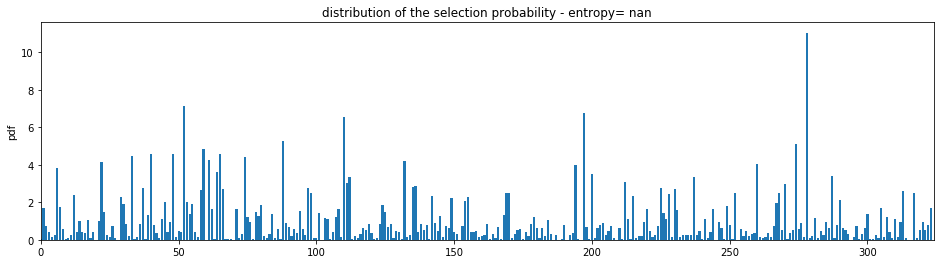

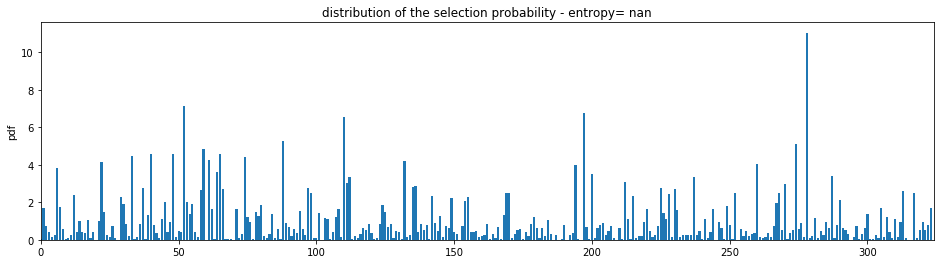

In [39]:

from shl_scripts.shl_encode import get_rescaling, mp
l0_sparseness = 50

sparse_code_mp = mp(data_test, dico_partial_learning.dictionary, P_cum=None, C=5., do_sym=do_sym, l0_sparseness=l0_sparseness, verbose=1)
sparse_code_comp = mp(data_test, dico_partial_learning.dictionary, P_cum=P_cum_zeroeffect, C=5., do_sym=do_sym, l0_sparseness=l0_sparseness, verbose=1)

#print('Difference = ', np.sum((sparse_code_mp - sparse_code_comp)**2))
#print('Relative difference = ', np.mean((sparse_code_mp - sparse_code_comp)**2))
#print('Variance = ', np.mean((sparse_code_mp)**2))
print('Relative difference = ', np.sum((sparse_code_mp - sparse_code_comp)**2)/np.sum((sparse_code_mp)**2))

fig, ax = plot_proba_histogram(sparse_code_mp)
fig.show()
fig, ax = plot_proba_histogram(sparse_code_comp)

In [40]:
n_samples, nb_filter = sparse_code_mp.shape

from shl_scripts.shl_encode import get_rescaling, mp

corr = (data_test @ dico_partial_learning.dictionary.T)
C_vec = get_rescaling(corr, nb_quant=nb_quant, verbose=True)

P_cum = np.vstack((P_cum_zeroeffect, C_vec))

print('Classical MP')
sparse_code_mp = mp(data_test, dico_partial_learning.dictionary, P_cum=None, C=np.inf, do_sym=do_sym, l0_sparseness=l0_sparseness, verbose=1)
print('Homeostatic MP')
sparse_code_comp = mp(data_test, dico_partial_learning.dictionary, P_cum=P_cum, C=0., do_sym=do_sym, l0_sparseness=l0_sparseness, verbose=1)

print('Relative difference = ', np.sum((sparse_code_mp - sparse_code_comp)**2)/np.sum((sparse_code_mp)**2))

Classical MP
coding duration : 89.88441371917725
Homeostatic MP
coding duration : 536.8180718421936
Relative difference =  0.122805037453


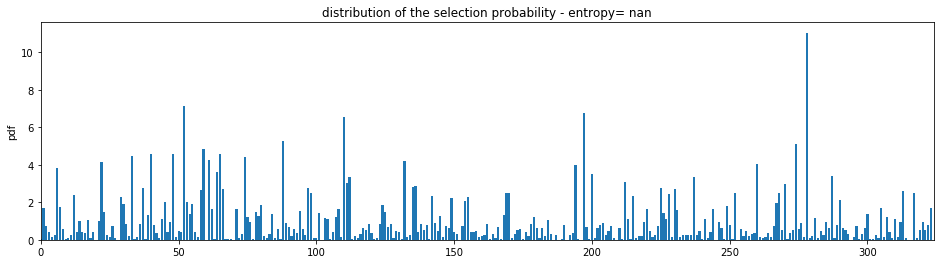

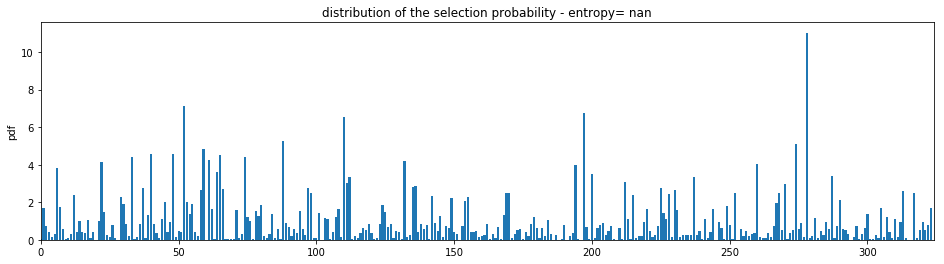

In [41]:
fig, ax = plot_proba_histogram(sparse_code_mp)
fig.show()
fig, ax = plot_proba_histogram(sparse_code_comp)

(81792, 324) (81792, 324)


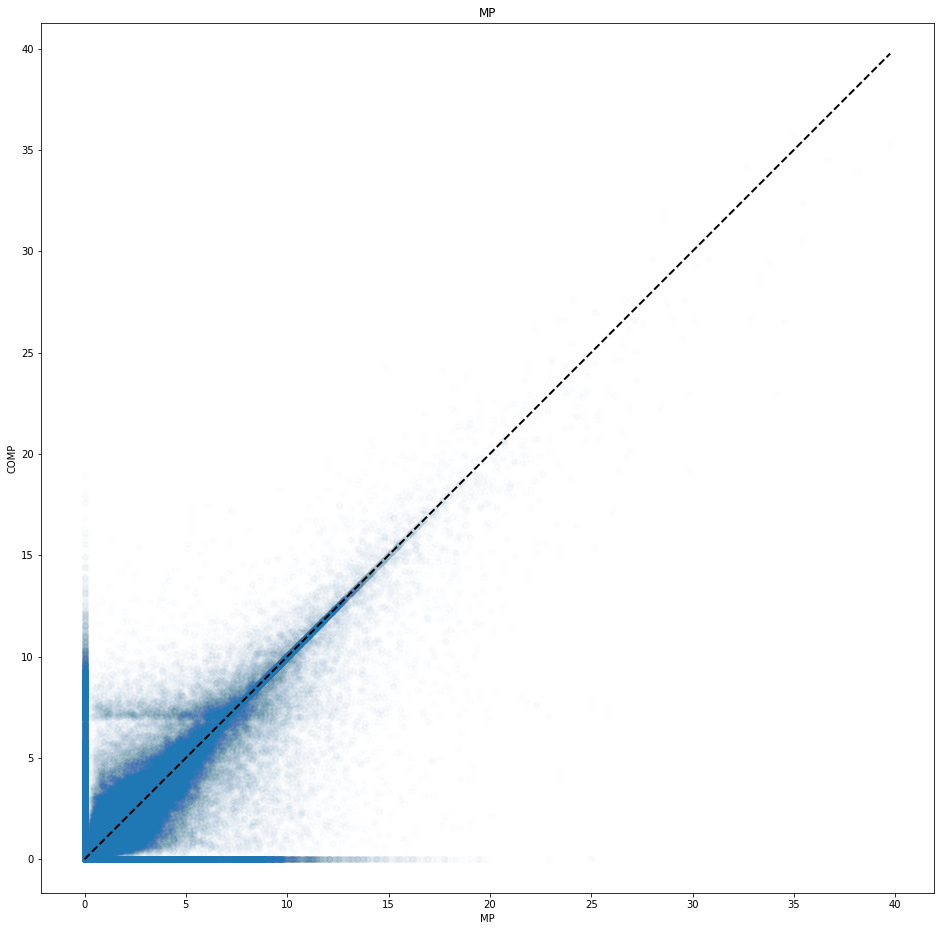

In [42]:
fig, ax = plot_scatter_MpVsComp(sparse_code_mp, sparse_code_comp)

## gradient descent 

First with one rescaling function, and varying ``P_cum`` functions.

Shape of modulation function (324, 512)
Shape of modulation function (325, 512)
Learning step 0


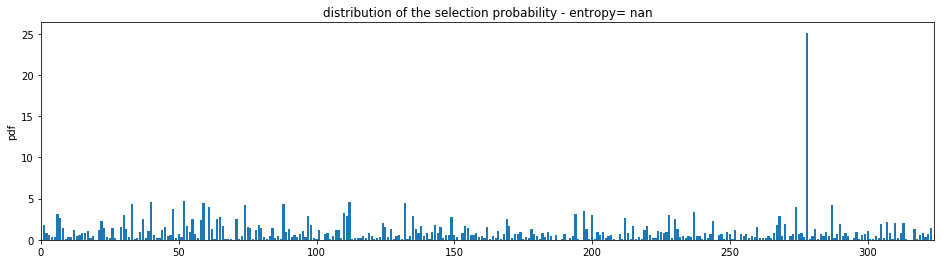

Learning step 100


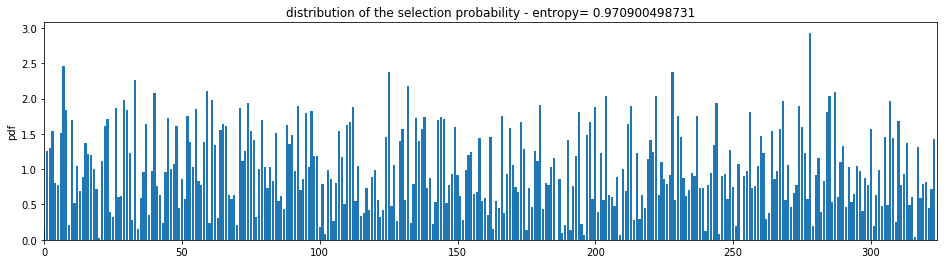

Learning step 200


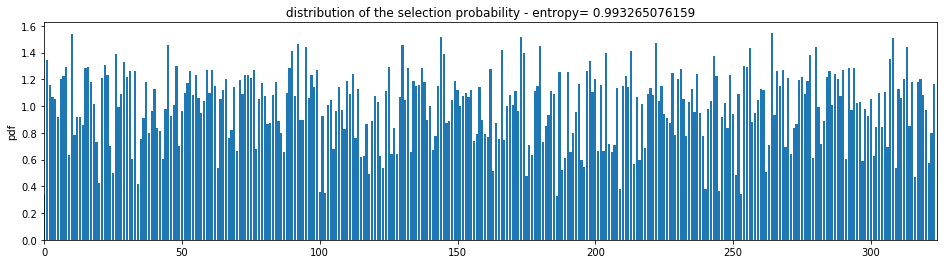

Learning step 300


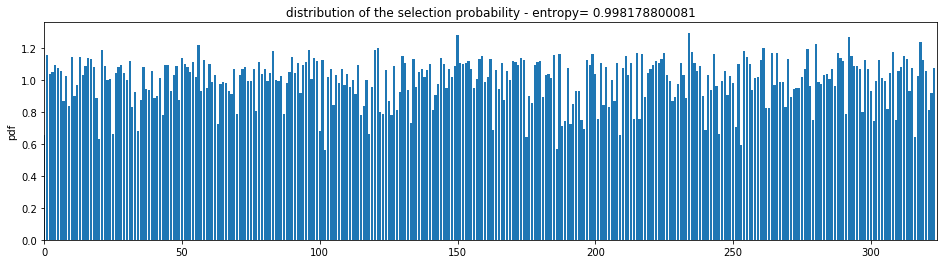

In [43]:
from shl_scripts.shl_learn import get_P_cum
from shl_scripts.shl_encode import get_rescaling, mp

corr = (data_test @ dico_partial_learning.dictionary.T)
C_vec = get_rescaling(corr, nb_quant=nb_quant, verbose=True)

P_cum = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((nb_filter, 1))
print('Shape of modulation function', P_cum.shape)
P_cum = np.vstack((P_cum, C_vec))
print('Shape of modulation function', P_cum.shape)

eta_homeo = .01

for i in range(400//DEBUG_DOWNSCALE):
    
    sparse_code = mp(data_test, dico_partial_learning.dictionary, P_cum=P_cum, C=0., do_sym=do_sym, verbose=0)
    P_cum_ = get_P_cum(sparse_code, nb_quant=nb_quant, C=C_vec)
    P_cum[:-1, :] = (1-eta_homeo) * P_cum[:-1, :] + eta_homeo  * P_cum_
    
    if i % (100//DEBUG_DOWNSCALE) == 0:
        print('Learning step', i)
        fig, ax = plot_proba_histogram(sparse_code)
        plt.show()

now by learning the rescaling function along with the ``P_cum`` functions.

Shape of modulation function (324, 512)
Shape of modulation function (325, 512)
Learning step 0


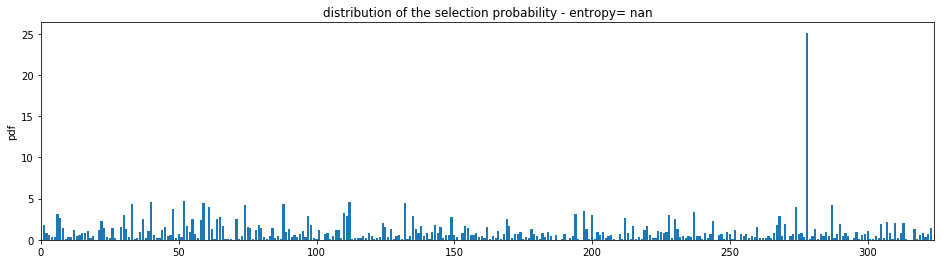

Learning step 100


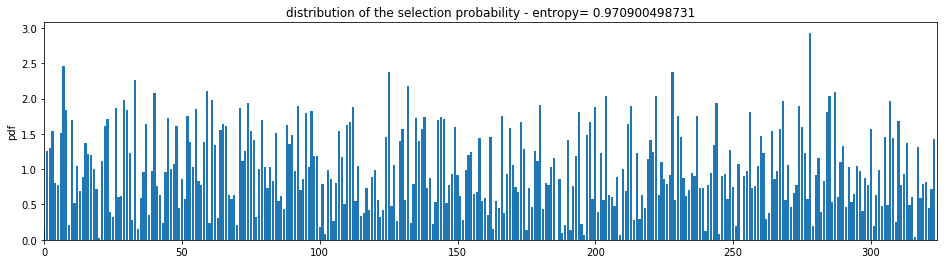

Learning step 200


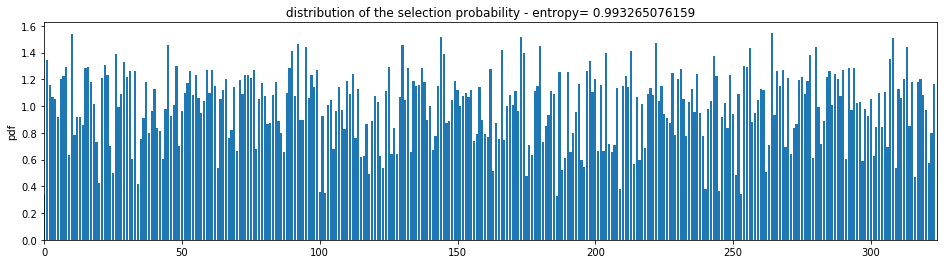

Learning step 300


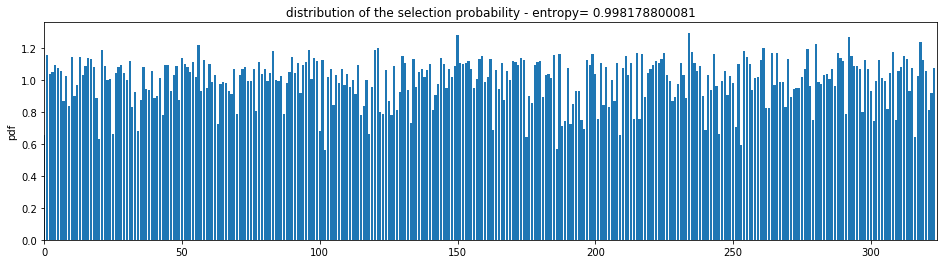

In [44]:
from shl_scripts.shl_learn import update_P_cum
from shl_scripts.shl_encode import get_rescaling, mp

corr = (data_test @ dico_partial_learning.dictionary.T)
C_vec= C_vec_init = get_rescaling(corr, nb_quant=nb_quant, verbose=True)

P_cum = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((nb_filter, 1))
print('Shape of modulation function', P_cum.shape)
P_cum = np.vstack((P_cum, C_vec))
print('Shape of modulation function', P_cum.shape)

eta_homeo = .01

for i in range(400//DEBUG_DOWNSCALE):
    
    sparse_code = mp(data_test, dico_partial_learning.dictionary, P_cum=P_cum, C=0., do_sym=do_sym, verbose=0)
    corr = (data_test @ dico_partial_learning.dictionary.T)
    C_vec = get_rescaling(corr, nb_quant=nb_quant, do_sym=do_sym, verbose=verbose)
    
    P_cum[-1, :]= (1 - eta_homeo) * P_cum[-1, :] + eta_homeo * C_vec
    P_cum[:-1, :] = update_P_cum(P_cum=P_cum[:-1, :], 
                                 code=sparse_code, eta_homeo=eta_homeo, 
                 C=P_cum[-1, :], nb_quant=nb_quant, do_sym=do_sym, verbose=verbose)

    if i % (100//DEBUG_DOWNSCALE) == 0:
        print('Learning step', i)
        fig, ax = plot_proba_histogram(sparse_code)
        plt.show()

Note how the rescaling function evolved during learning 

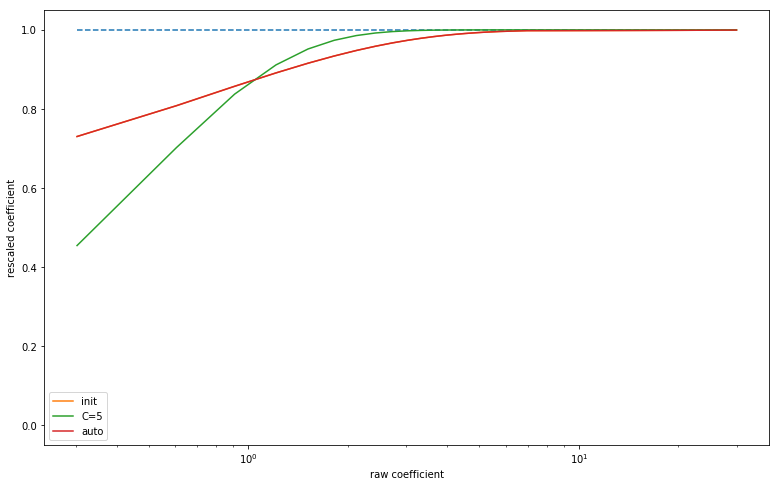

In [45]:
fig=plt.figure(figsize=(13, 8))
ax = plt.subplot(111)
x = np.linspace(0, 30, 100)
ax.plot(x, np.ones_like(x), '--')
ax.plot(x, rescaling(x, C=C_vec_init, do_sym=do_sym), label='init')
ax.plot(x, rescaling(x, C=.5, do_sym=do_sym), label='C=5')
ax.plot(x, rescaling(x, C=C_vec, do_sym=do_sym), label='auto')
ax.set_xlabel('raw coefficient')
ax.set_ylabel('rescaled coefficient')
ax.set_xscale('log')
ax.axis('tight')
ax.legend(loc='best');

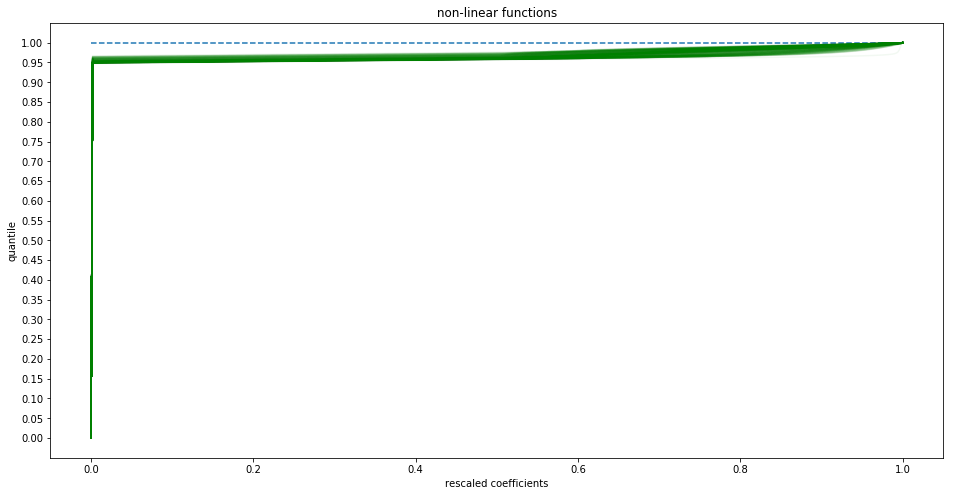

In [46]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum[:-1, :], verbose=False);

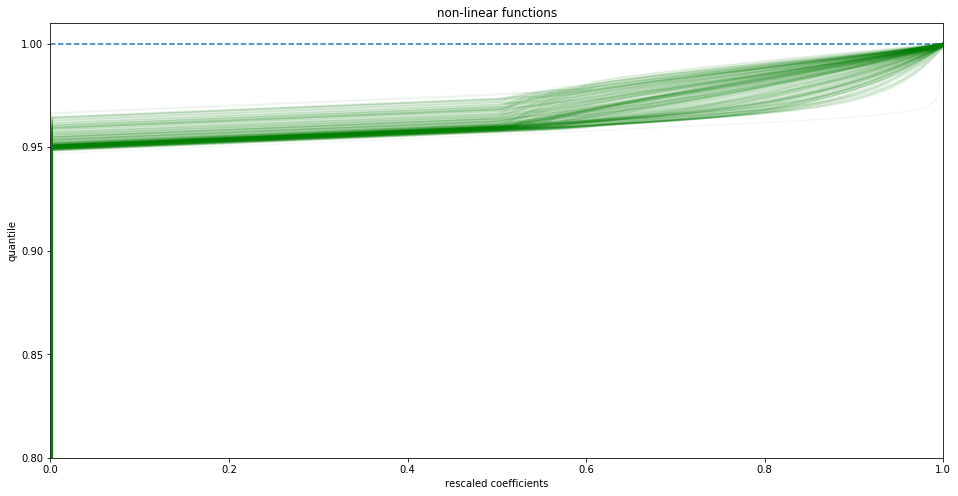

In [47]:
fig, ax = plot_P_cum(P_cum[:-1, :], verbose=False)
ax.set_ylim(0.8, 1.01);ax.set_xlim(0., 1.);

Similar to the [previous post](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps-pcum.html), one observes that the distribution gets progressively more uniform which was our goal.  This implementation makes the Matching Pursuit algorithm running faster such that we can integrate it to the [SHL package](https://github.com/bicv/SHL_scripts). This was done in this [commit](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps-fastpcum_scripted.html).

## finally...

Let's try the whole learning process with the adaptive rescaling function:

In [48]:
from shl_scripts.shl_experiments import SHL
matname = tag + '_autohomeo'
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE,
          datapath='/tmp/database',
          data_cache='/tmp/data_cache',
          verbose=2, 
          homeo_method='HAP', homeo_params=dict(alpha_homeo=0., C=0.), 
          do_sym=do_sym, nb_quant=nb_quant)
data = shl.get_data(matname=matname)

loading the data called : /tmp/data_cache/2017-12-01_Testing_COMPs_autohomeo_data


In [49]:
test_size = data.shape[0]//2
data_training = data[:test_size, :]
data_test = data[test_size:,:]   
if DEBUG:
    test_size = data.shape[0]//20
    data_training = data[:(data.shape[0]-test_size),:].copy()
    data_test = data[:test_size, :].copy()

In [50]:
dico_partial_learning = shl.learn_dico(data=data_training, matname=matname)

loading the dico called : /tmp/data_cache/2017-12-01_Testing_COMPs_autohomeo_dico.pkl


We start off by using a short learning with no homeostasis such that we end up with a unbalanced dictionary:

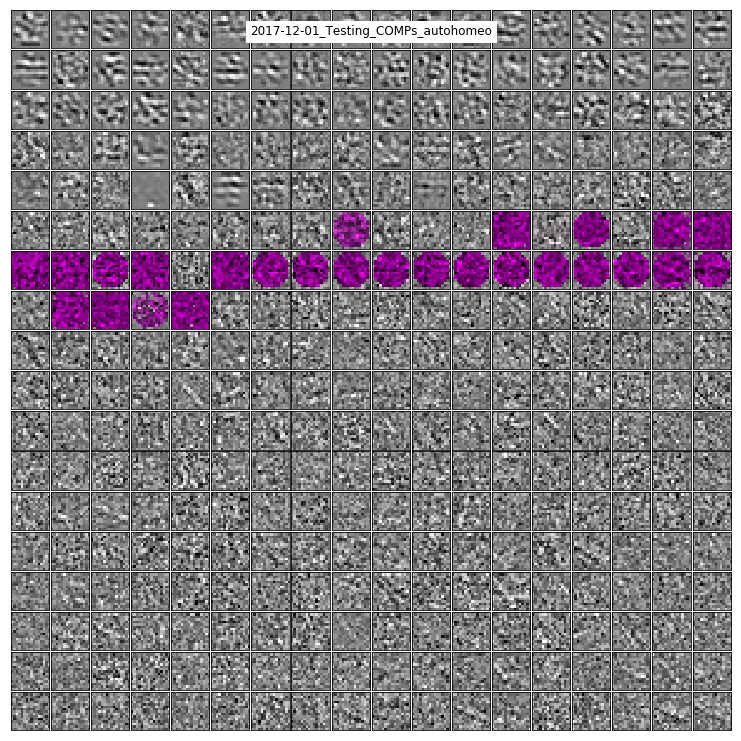

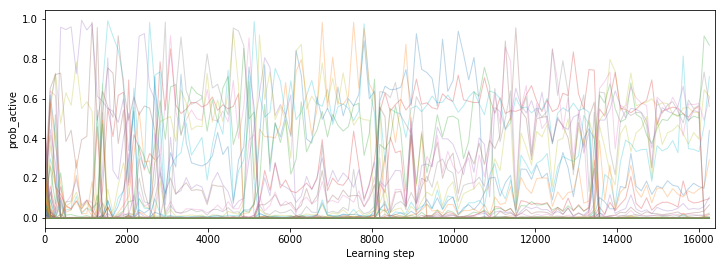

In [51]:
fig, ax = shl.show_dico(dico_partial_learning, data=data, title=matname)
fig.show()
fig, ax = shl.time_plot(dico_partial_learning, variable='prob_active');
fig.show()